In [49]:
# Loads imagenette data set
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    trust_remote_code=True
)
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

In [50]:

# Saves 25 random images from the imagenette dataset and saves to class 4 raw data.
'''
import os
from datasets import load_dataset
from PIL import Image

# Select 25 random images
imagenette_sample = imagenette.shuffle(seed=42).select(range(25))

# Create a directory to save images
save_dir = "../data/raw/class4"
os.makedirs(save_dir, exist_ok=True)

# Save images to the directory
for i, example in enumerate(imagenette_sample):
    img = example["image"]  # Get image object
    img_path = os.path.join(save_dir, f"imagenette_{i+1}.png")
    img.save(img_path)  # Save image

print(f"Saved {len(imagenette_sample)} images to {save_dir}/")
'''

'\nimport os\nfrom datasets import load_dataset\nfrom PIL import Image\n\n# Select 25 random images\nimagenette_sample = imagenette.shuffle(seed=42).select(range(25))\n\n# Create a directory to save images\nsave_dir = "../data/raw/class4"\nos.makedirs(save_dir, exist_ok=True)\n\n# Save images to the directory\nfor i, example in enumerate(imagenette_sample):\n    img = example["image"]  # Get image object\n    img_path = os.path.join(save_dir, f"imagenette_{i+1}.png")\n    img.save(img_path)  # Save image\n\nprint(f"Saved {len(imagenette_sample)} images to {save_dir}/")\n'

In [51]:
# Defined function creates list of paths to test images
def add_data(path_string, image_paths):
    for i in range(1, 26):
        image_paths.append({"image": ["%s%d.png" % (path_string, i)]})

In [52]:
# Creates custom dataset using star cluster images
from datasets import Dataset, Image, concatenate_datasets
image_paths = []

# Calls the function to add 75 star cluster images (25 of each class) and 25 images from imagenette
add_data("..\\data\\raw\\class1\\class1_image_", image_paths)
add_data("..\\data\\raw\\class2\\class2_image_", image_paths)
add_data("..\\data\\raw\\class3\\class3_image_", image_paths)
add_data("..\\data\\raw\\class4\\imagenette_", image_paths)

dataset = Dataset.from_dict({"image": [item["image"][0] for item in image_paths]}).cast_column("image", Image())

# Creates labels for each image in dataset for future verification
labels = [1]*25 + [2]*25 + [3]*25 + [4]*25
dataset = dataset.add_column("label", labels)



In [53]:
# Imports CLIP libraries
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# Sets computation device to whatever is available (likely CPU in this case)
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

# Specifices version of CLIP to be used from huggingface 
model_id = "openAI/clip-vit-base-patch32"

# Loads the model, tokenizer, and processor
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)


In [54]:
# Sets input prompt and tokenizes it using tokenizer

prompt_one = "a compact star cluster with dark center and symmetrical body"
prompt_two = "dispersed stellar association with no clear center and asymmetrical body"
prompt_three = "parachute, golf ball, fish, chainsaw"

inputs_one = tokenizer(prompt_one, return_tensors="pt")
inputs_two = tokenizer(prompt_two, return_tensors="pt")
inputs_three = tokenizer(prompt_three, return_tensors="pt")
inputs_one

{'input_ids': tensor([[49406,   320, 13690,  1565, 15595,   593,  3144,  2119,   537,  3645,
         40704,  1774, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [55]:
# Embeds the prompt into a vector space in shape suitable for the model
text_emb_one = model.get_text_features(**inputs_one)
text_emb_two = model.get_text_features(**inputs_two)
text_emb_three = model.get_text_features(**inputs_three)
text_emb_one.shape

torch.Size([1, 512])

In [56]:
# Processor is used for image and text processing, however this instance is only for images and returns it as a tensor.
image = processor(
    text=None,
    images=dataset[0]['image'], #Custom cluster dataset
    # images=dataset[0]['image'], #Imagenette dataset 
    return_tensors="pt"
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [57]:
image.squeeze(0).T.shape


torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


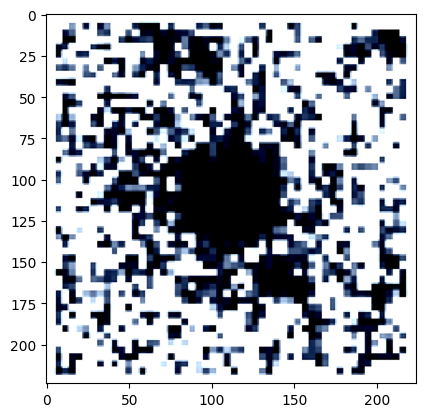

In [58]:
# Displays processed image 
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0).T)


In [59]:
# Embeds image into vector space, similar to text embedding 
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [60]:
import numpy as np 

# The following code selects a random set of 50 images for testing
np.random.seed(0)
sample_idx = np.random.randint(0, len(dataset), 50).tolist() #custom cluster dataset
images = [dataset[i]['image'] for i in sample_idx] # custom cluster dataset
labels = [dataset[i]['label'] for i in sample_idx] 

# sample_idx = np.random.randint(0, len(imagenette), 50).tolist() # imagentte dataset
# images = [imagenette[i]['image'] for i in sample_idx] #imagenette dataset

len(images)

50

In [61]:
from tqdm.auto import tqdm

batch_size = 10 # change depending on size of test set
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    #conver to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    #add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape



  0%|          | 0/5 [00:00<?, ?it/s]

(50, 512)

In [62]:
image_arr.min(), image_arr.max() 

(np.float32(-7.2155), np.float32(2.7587738))

In [63]:
# Normalizes the image embeddings
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

In [64]:
image_arr = image_arr.T
image_arr.shape
image_arr.min(), image_arr.max()

(np.float32(-0.6775018), np.float32(0.24947001))

In [65]:
text_emb_one = text_emb_one.cpu().detach().numpy()
text_emb_two = text_emb_two.cpu().detach().numpy()
text_emb_three = text_emb_three.cpu().detach().numpy()

In [66]:
# Takes the dot product of each image and the prompt to determine similarities scores
scores_one = np.dot(text_emb_one, image_arr.T)
scores_two = np.dot(text_emb_two, image_arr.T)
scores_three = np.dot(text_emb_three, image_arr.T)

In [67]:
# Takes the top 5 image scores for prompt 1 and stores them in an index array
top_k = 50
idx_one = np.argsort(-scores_one[0])[:top_k]
idx_one

array([ 1, 30, 35, 26,  0,  7, 28, 48, 36, 37, 38, 13, 49, 46, 40, 16, 45,
       41,  4,  3, 44,  8, 42, 15, 47,  2, 31, 14, 24, 18, 22, 10, 25, 43,
        5, 21, 39, 32, 33, 20,  9, 17, 23,  6, 27, 29, 11, 12, 19, 34])

2.2437904


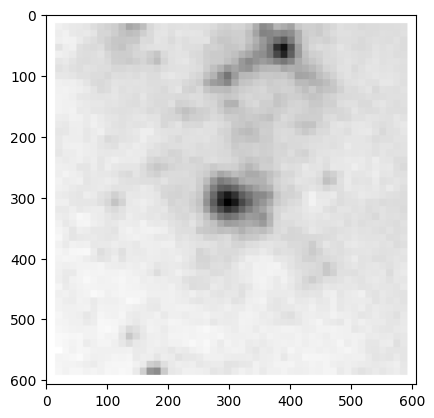

2


In [68]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_one[0][idx_one[i]])
    plt.imshow(images[idx_one[i]])
    plt.show()
    print(labels[idx_one[i]])

In [69]:
# Takes the top 5 image scores for prompt 2 and stores them in an index array
top_k = 50
idx_two = np.argsort(-scores_two[0])[:top_k]

2.941014


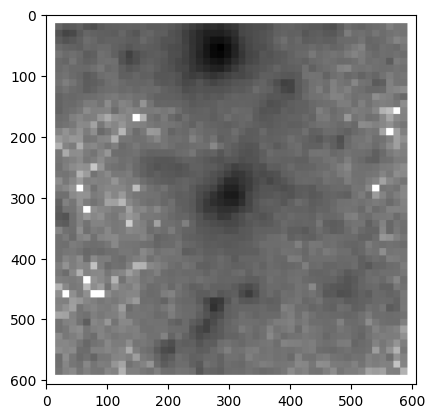

2


In [70]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_two[0][idx_two[i]])
    plt.imshow(images[idx_two[i]])
    plt.show()
    print(labels[idx_two[i]])

In [71]:
# Takes the top 5 image scores for prompt 3 and stores them in an index array
top_k = 50
idx_three = np.argsort(-scores_three[0])[:top_k]

2.650889


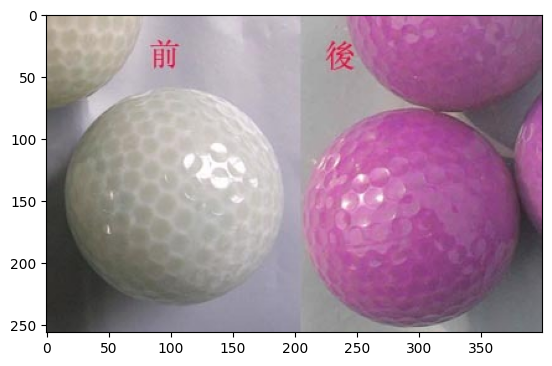

4


In [72]:
# Prints the 5 images with the highest scores

for i in range(1):
    print(scores_three[0][idx_three[i]])
    plt.imshow(images[idx_three[i]])
    plt.show()
    print(labels[idx_three[i]])


In [ ]:
# Finds earliest occurence of each image in score indexes and assigns them to respective category
# Convert lists to dictionaries for O(1) lookups
pos_one = {img: i for i, img in enumerate(idx_one)}
pos_two = {img: i for i, img in enumerate(idx_two)}
pos_three = {img: i for i, img in enumerate(idx_three)}

cat_one = []
cat_two = []
cat_three = []

# Get unique images from all three lists
all_images = set(idx_one) | set(idx_two) | set(idx_three)

for img in all_images:
    # Get positions, using a large default if missing
    pos1 = pos_one.get(img, float('inf'))
    pos2 = pos_two.get(img, float('inf'))
    pos3 = pos_three.get(img, float('inf'))

    # Determine which list contains the earliest occurrence
    min_pos = min(pos1, pos2, pos3)

    if min_pos == pos1:
        cat_one.append(img)
    elif min_pos == pos2:
        cat_two.append(img)
    elif min_pos == pos3:
        cat_three.append(img)


np.int64(2)

In [74]:
# Defined function to calculate scores of each classification based on the categories corresponding to each prompt and the desired classification for each prompt
# Cat_list is the list of images given a speific category, targets are the target classifications for those categories
def calculate_score(cat_list, targets):
    score = 0
    total = 0
    for i in cat_list:
        if labels[i] == targets[0]:
            score = score + 1 
        if len(targets) > 1:
            if labels[i] == targets[1]:
                score = score + 1
        total = total + 1
    return (score/total)*100

In [75]:
# Prints accuracy as a percentage for each category
score1 = calculate_score(cat_one, [1, 2])
score2 = calculate_score(cat_two, [3])
score3 = calculate_score(cat_three, [4])

print(f"The prompt looking for open and globular clusters has a {score1}% success rate!")
print(f"The prompt looking for stellar associations has a {score2}% success rate!")
print(f"The prompt looking for everyday objects has a {score3}% success rate!")


The prompt looking for open and globular clusters has a 56.25% success rate!
The prompt looking for stellar associations has a 0.0% success rate!
The prompt looking for everyday objects has a 38.095238095238095% success rate!


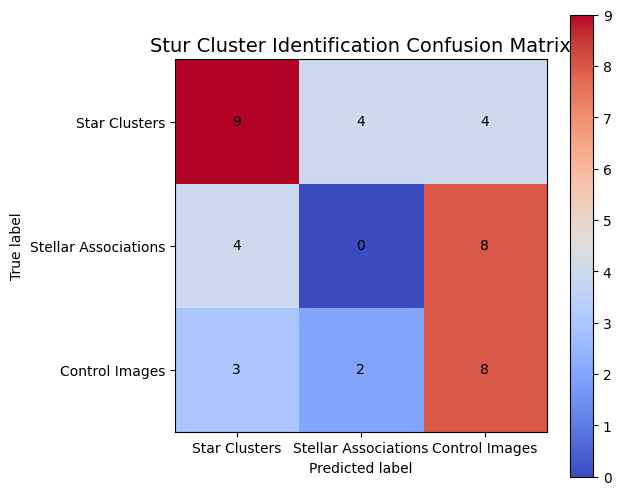

In [94]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

actual = []
predicted = []

for i in cat_one:
    if labels[i] == 2:
        actual.append(1)
    else:
        actual.append(labels[i])
    predicted.append(1) 

for i in cat_two:
    actual.append(labels[i])
    predicted.append(3)

for i in cat_three:
    actual.append(labels[i])
    predicted.append(4)

actual = np.array(actual)
predicted = np.array(predicted)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[1, 3, 4])

category_labels = ["Star Clusters", "Stellar Associations", "Control Images"]

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=category_labels)
fig, ax = plt.subplots(figsize=(6, 6))  # Set figure size
cm_display.plot(cmap="coolwarm", ax=ax, values_format="d") 

for text in ax.texts:
    text.set_color("black")

plt.title("Stur Cluster Identification Confusion Matrix", fontsize=14)
plt.show()
